In [2]:
%pip install pandas
%pip install numpy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [80]:
import pandas as pd
import numpy as np

# Simulate a dataset
np.random.seed(42)
num_samples_per_day = 40000
days = 30  # Example: Generate for 30 days

# Initialize an empty DataFrame
df = pd.DataFrame()

def normalize_probs(probs):
    prob_sum = sum(probs)
    if not np.isclose(prob_sum, 1.0):
        probs = [float(p) / prob_sum for p in probs]
    return probs

def get_event_type_prob(hour, include_anomalies=False):
    # Map hour to time period
    if hour < 6:
        time_period = 'early_morning'
    elif hour < 12:
        time_period = 'morning_to_noon'
    else:
        time_period = 'afternoon_to_night'

    # Define normal probabilities
    normal_probs = {
        'early_morning': [0.5, 0.1, 0.1, 0.2, 0.1],
        'morning_to_noon': [0.2, 0.2, 0.2, 0.2, 0.2],
        'afternoon_to_night': [0.1, 0.3, 0.2, 0.1, 0.3]
    }

    # Adjust probabilities for anomalies
    anomaly_probs = {
        'early_morning': [0.3, 0.5, 0.1, 0.1, 0.1],
        'morning_to_noon': [0.1, 0.7, 0.1, 0.1, 0.1],
        'afternoon_to_night': [0.1, 0.5, 0.2, 0.1, 0.1]
    }

    if include_anomalies:
        return ['low_balance', 'fraud_alert', 'transaction_threshold', 'payment_due', 'overdraft'], normalize_probs(anomaly_probs[time_period])

    return ['low_balance', 'fraud_alert', 'transaction_threshold', 'payment_due', 'overdraft'], normalize_probs(normal_probs[time_period])

def adjust_samples_by_day(day):
    if day in [28, 29, 30]:  # End of the month might have more low_balance events
        return 0.6  # Increase the probability of low_balance
    return 0.1  # Normal probability

def get_user_event_prob(user_id):
    if user_id % 10 == 0:  # Example condition
        return 0.5  # Higher chance of fraud_alert for certain users
    return 0.1

def generate_data(days, include_anomalies=False):
    df = pd.DataFrame() 
    for day in range(days):
        start_date = pd.Timestamp('2023-01-01') + pd.Timedelta(days=day)
        hourly_periods = 24  # Number of hours in a day

        samples_per_hour = num_samples_per_day // hourly_periods
        remainder_samples = num_samples_per_day % hourly_periods

        timestamps = []
        events = []
        user_ids = []

        for hour in range(hourly_periods):
            hour_samples = samples_per_hour + 1 if hour < remainder_samples else samples_per_hour
            event_types, probs = get_event_type_prob(hour)
            
            # Adjust the probability for 'low_balance' based on the day of the month
            low_balance_prob_adjustment = adjust_samples_by_day(day)
            if 'low_balance' in event_types:
                low_balance_index = event_types.index('low_balance')
                probs[low_balance_index] += low_balance_prob_adjustment
                probs = normalize_probs(probs)  # Normalize again after adjustment

            for _ in range(hour_samples):
                user_id = np.random.randint(1000, 1100)
                user_ids.append(user_id)
                fraud_alert_prob = get_user_event_prob(user_id)

                # Decide event type based on adjusted probabilities
                if np.random.rand() < fraud_alert_prob:
                    events.append('fraud_alert')
                else:
                    events.append(np.random.choice(event_types, p=probs))

                timestamps.append(pd.Timestamp(start_date + pd.Timedelta(hours=hour)))
            
            print(f"Probabilities for hour {hour}: {probs}, Sum: {sum(probs)}")  # Debugging line

        # Ensure all arrays are of the same length
        if len(timestamps) != num_samples_per_day:
            raise ValueError(f"Timestamps generated: {len(timestamps)}, expected: {num_samples_per_day}")

        chunk_data = {
            'timestamp': timestamps,
            'event_type': events,
            'user_id': user_ids,
            'account_id': np.random.randint(2000, 2100, num_samples_per_day),
            'transaction_amount': np.random.uniform(10, 500, num_samples_per_day),
            'threshold': np.random.uniform(50, 100, num_samples_per_day),
            'metadata': np.random.choice(['metadata1', 'metadata2', 'metadata3'], num_samples_per_day)
        }

        chunk_df = pd.DataFrame(chunk_data)
        df = pd.concat([df, chunk_df], ignore_index=True)
    return df

# Verify DataFrame size

train_df = generate_data(30, include_anomalies=False)
test_df = generate_data(30, include_anomalies=True)

print(len(train_df))
print(len(test_df))

train_df.head()



Probabilities for hour 0: [0.5454545454545454, 0.09090909090909091, 0.09090909090909091, 0.18181818181818182, 0.09090909090909091], Sum: 1.0
Probabilities for hour 1: [0.5454545454545454, 0.09090909090909091, 0.09090909090909091, 0.18181818181818182, 0.09090909090909091], Sum: 1.0
Probabilities for hour 2: [0.5454545454545454, 0.09090909090909091, 0.09090909090909091, 0.18181818181818182, 0.09090909090909091], Sum: 1.0
Probabilities for hour 3: [0.5454545454545454, 0.09090909090909091, 0.09090909090909091, 0.18181818181818182, 0.09090909090909091], Sum: 1.0
Probabilities for hour 4: [0.5454545454545454, 0.09090909090909091, 0.09090909090909091, 0.18181818181818182, 0.09090909090909091], Sum: 1.0
Probabilities for hour 5: [0.5454545454545454, 0.09090909090909091, 0.09090909090909091, 0.18181818181818182, 0.09090909090909091], Sum: 1.0
Probabilities for hour 6: [0.2727272727272728, 0.18181818181818185, 0.18181818181818185, 0.18181818181818185, 0.18181818181818185], Sum: 1.000000000000000

,timestamp,event_type,user_id,account_id,transaction_amount,threshold,metadata
0,2023-01-01,payment_due,1051,2005,320.410292,53.397570,metadata1
1,2023-01-01,low_balance,1060,2011,236.981791,53.545650,metadata1
2,2023-01-01,fraud_alert,1086,2001,152.189398,82.084153,metadata2
3,2023-01-01,low_balance,1087,2090,459.058168,65.783802,metadata3
4,2023-01-01,fraud_alert,1002,2076,450.327977,64.871687,metadata3


In [81]:
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
train_df['hour_of_day'] = train_df['timestamp'].dt.hour
train_df['day_of_week'] = train_df['timestamp'].dt.dayofweek
train_df['month'] = train_df['timestamp'].dt.month

train_df.head()

,timestamp,event_type,user_id,account_id,transaction_amount,threshold,metadata,hour_of_day,day_of_week,month
0,2023-01-01,payment_due,1051,2005,320.410292,53.397570,metadata1,0,6,1
1,2023-01-01,low_balance,1060,2011,236.981791,53.545650,metadata1,0,6,1
2,2023-01-01,fraud_alert,1086,2001,152.189398,82.084153,metadata2,0,6,1
3,2023-01-01,low_balance,1087,2090,459.058168,65.783802,metadata3,0,6,1
4,2023-01-01,fraud_alert,1002,2076,450.327977,64.871687,metadata3,0,6,1


In [82]:
# Print current columns to check if 'event_type' and 'metadata' are present
print(train_df.columns)

# Conditionally apply get_dummies if columns exist
columns_to_encode = [col for col in ['event_type', 'metadata'] if col in train_df.columns]
if columns_to_encode:
    train_df = pd.get_dummies(train_df, columns=columns_to_encode, drop_first=False)
else:
    print("Columns for encoding not found in DataFrame.")

train_df.head()

Index(['timestamp', 'event_type', 'user_id', 'account_id',
       'transaction_amount', 'threshold', 'metadata', 'hour_of_day',
       'day_of_week', 'month'],
      dtype='object')


,timestamp,user_id,account_id,transaction_amount,threshold,hour_of_day,day_of_week,month,event_type_fraud_alert,event_type_low_balance,event_type_overdraft,event_type_payment_due,event_type_transaction_threshold,metadata_metadata1,metadata_metadata2,metadata_metadata3
0,2023-01-01,1051,2005,320.410292,53.397570,0,6,1,False,False,False,True,False,True,False,False
1,2023-01-01,1060,2011,236.981791,53.545650,0,6,1,False,True,False,False,False,True,False,False
2,2023-01-01,1086,2001,152.189398,82.084153,0,6,1,True,False,False,False,False,False,True,False
3,2023-01-01,1087,2090,459.058168,65.783802,0,6,1,False,True,False,False,False,False,False,True
4,2023-01-01,1002,2076,450.327977,64.871687,0,6,1,True,False,False,False,False,False,False,True


In [69]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numerical_features = ['transaction_amount', 'threshold']
train_df[numerical_features] = scaler.fit_transform(train_df[numerical_features])

train_df.head()


,timestamp,user_id,account_id,transaction_amount,threshold,hour_of_day,day_of_week,month,event_type_fraud_alert,event_type_low_balance,event_type_overdraft,event_type_payment_due,event_type_transaction_threshold,metadata_metadata1,metadata_metadata2,metadata_metadata3
0,2023-01-01,1070,2021,0.949737,1.686384,0,6,1,False,False,False,True,False,True,False,False
1,2023-01-01,1055,2068,-1.356672,0.278200,0,6,1,True,False,False,False,False,True,False,False
2,2023-01-01,1090,2058,0.338386,-0.917481,0,6,1,False,False,False,False,True,True,False,False
3,2023-01-01,1025,2022,1.136745,0.410978,0,6,1,False,True,False,False,False,False,True,False
4,2023-01-01,1002,2061,-0.697544,1.624391,0,6,1,False,False,True,False,False,False,True,False


In [7]:
%pip install matplotlib
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


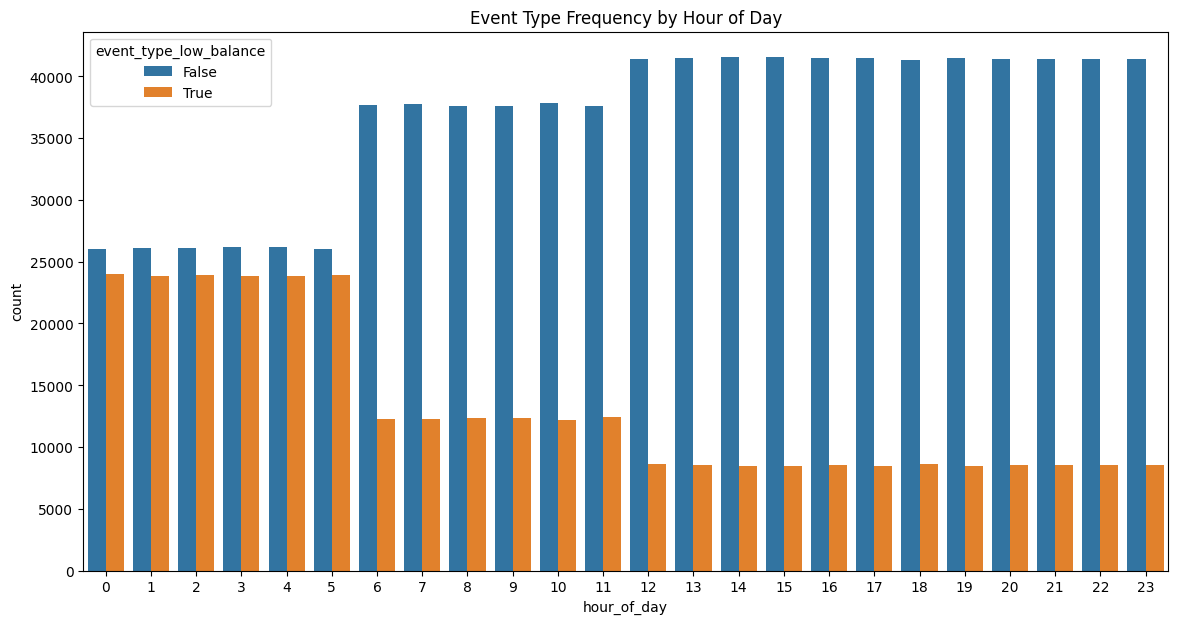

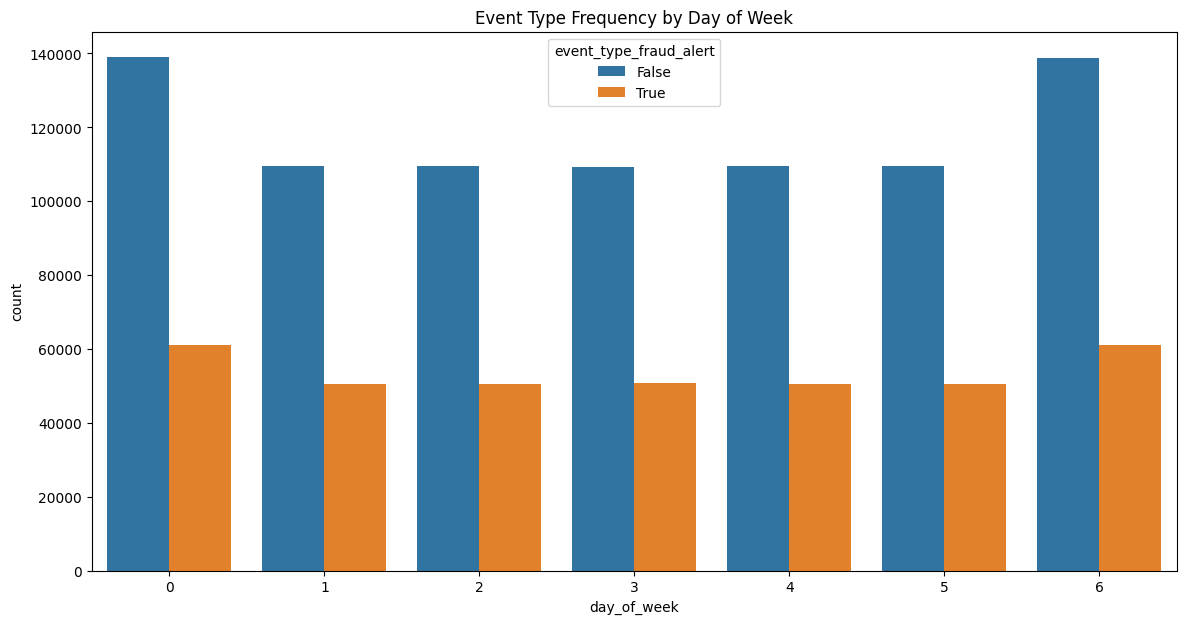

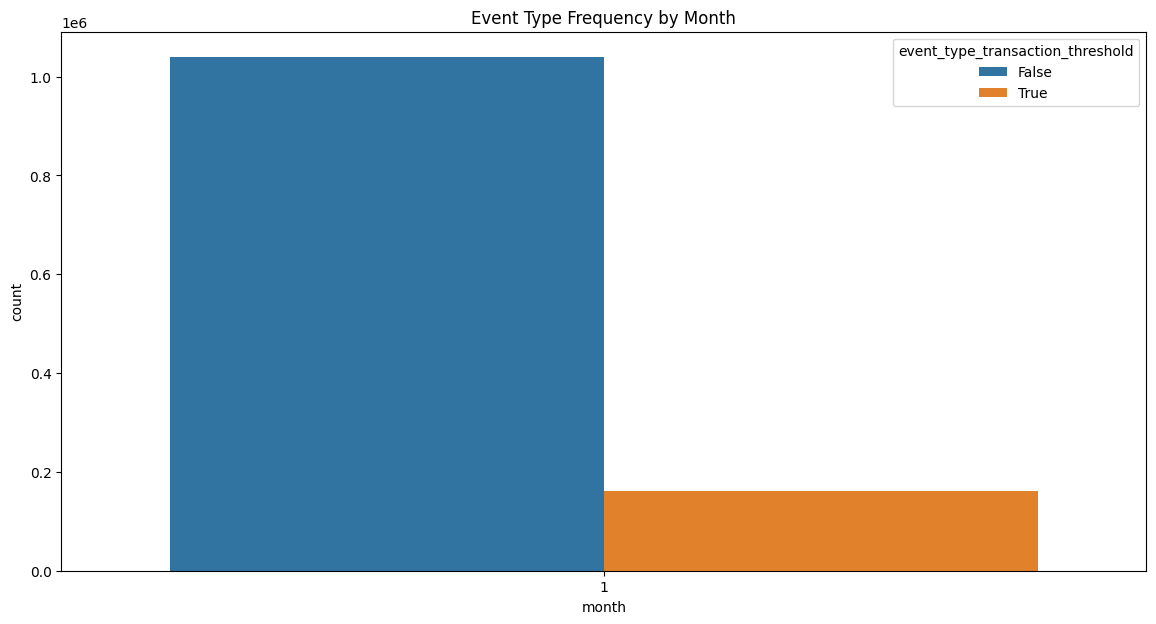

Index(['timestamp', 'user_id', 'account_id', 'transaction_amount', 'threshold',
       'hour_of_day', 'day_of_week', 'month', 'event_type_fraud_alert',
       'event_type_low_balance', 'event_type_overdraft',
       'event_type_payment_due', 'event_type_transaction_threshold',
       'metadata_metadata1', 'metadata_metadata2', 'metadata_metadata3'],
      dtype='object')


In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the frequency of different event types over time
plt.figure(figsize=(14, 7))
sns.countplot(data=train_df, x='hour_of_day', hue='event_type_low_balance')
plt.title('Event Type Frequency by Hour of Day')
plt.show()

plt.figure(figsize=(14, 7))
sns.countplot(data=train_df, x='day_of_week', hue='event_type_fraud_alert')
plt.title('Event Type Frequency by Day of Week')
plt.show()

plt.figure(figsize=(14, 7))
sns.countplot(data=train_df, x='month', hue='event_type_transaction_threshold')
plt.title('Event Type Frequency by Month')
plt.show()

print(train_df.columns)


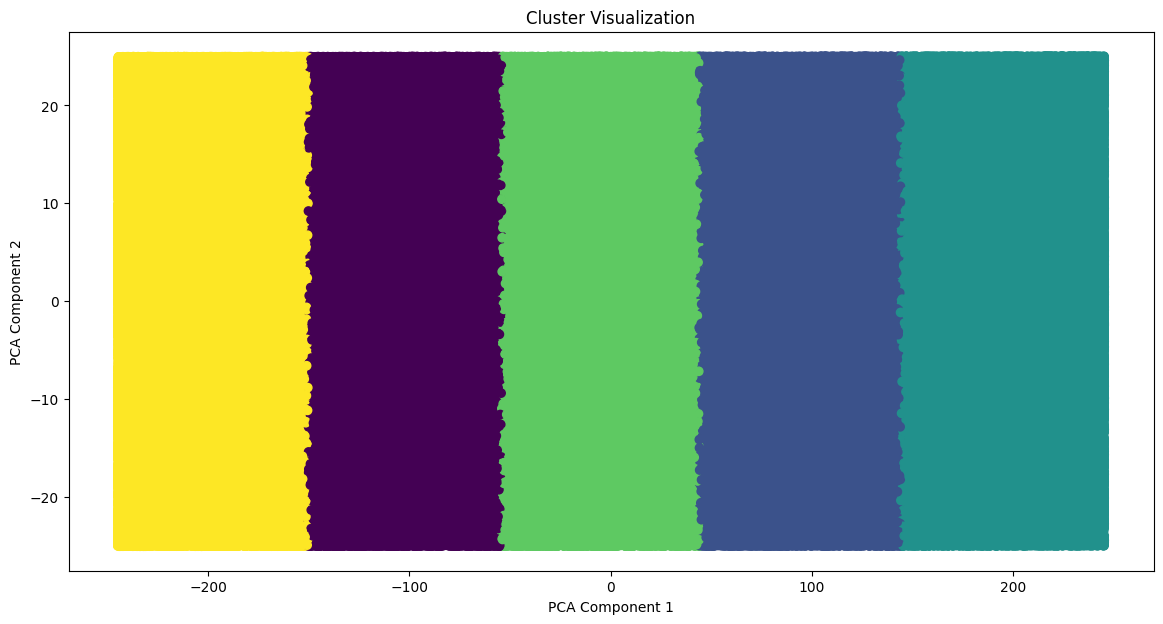

In [84]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Reduce dimensions for clustering
pca = PCA(n_components=3)
reduced_features = pca.fit_transform(train_df.drop(['timestamp', 'user_id', 'account_id'], axis=1))

print(pca.explained_variance_ratio_)

# Apply KMeans
kmeans = KMeans(n_clusters=5)
train_df['cluster'] = kmeans.fit_predict(reduced_features)

# Visualize clusters
plt.figure(figsize=(14, 7))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=train_df['cluster'], cmap='viridis')
plt.title('Cluster Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()



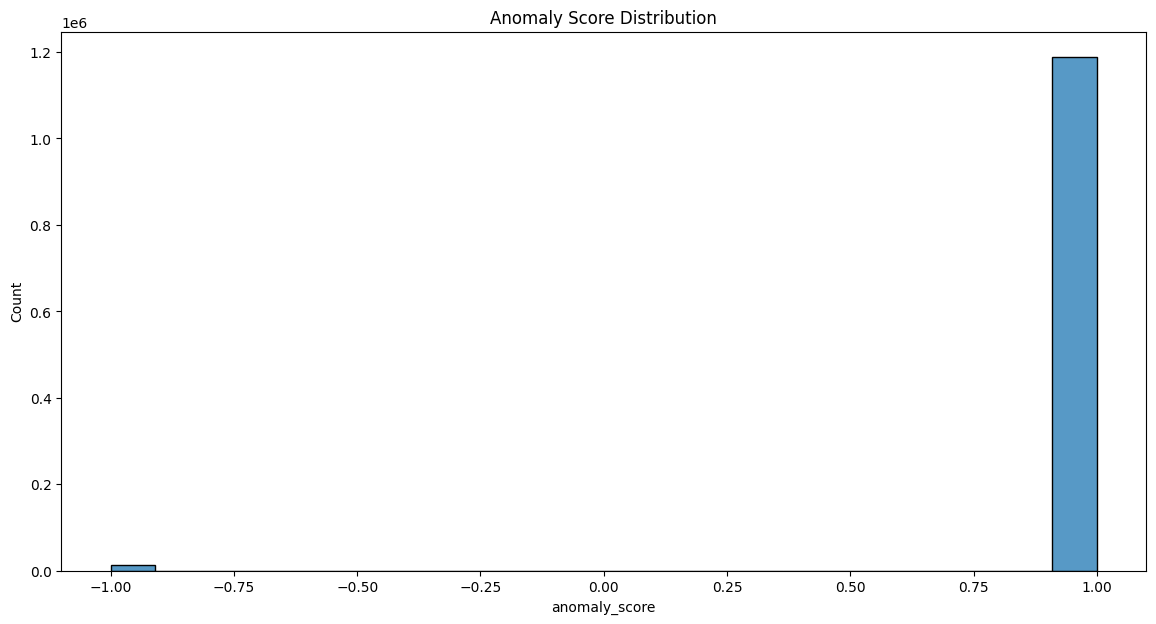

In [85]:
from sklearn.ensemble import IsolationForest

# Train Isolation Forest
iso_forest = IsolationForest(contamination=0.01)
train_df['anomaly_score'] = iso_forest.fit_predict(train_df.drop(['timestamp', 'user_id', 'account_id', 'cluster'], axis=1))

# Visualize Anomaly Scores
plt.figure(figsize=(14, 7))
sns.histplot(train_df['anomaly_score'])
plt.title('Anomaly Score Distribution')
plt.show()


In [86]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Simulate labels for demonstration purposes
train_df['is_anomaly'] = np.random.choice([0, 1], size=num_samples_per_day * 30, p=[0.95, 0.05])

# Split data
X = train_df.drop(['timestamp', 'user_id', 'account_id', 'cluster', 'anomaly_score', 'is_anomaly'], axis=1)
y = train_df['is_anomaly']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Evaluate
y_pred = rf.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.95      1.00      0.97    227985
           1       0.06      0.00      0.00     12015

    accuracy                           0.95    240000
   macro avg       0.51      0.50      0.49    240000
weighted avg       0.91      0.95      0.93    240000



In [21]:
%pip install keras

Note: you may need to restart the kernel to use updated packages.


In [87]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



# Assuming df is your DataFrame and 'is_anomaly' is the target variable
X = train_df.drop(['timestamp', 'is_anomaly'], axis=1).values  # Exclude 'timestamp' and any other non-numeric columns
y = train_df['is_anomaly'].values

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape input to be [samples, time steps, features]
X_scaled = np.reshape(X_scaled, (X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(1, X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

# Evaluate the model
_, accuracy = model.evaluate(X_test, y_test)
print(f"Model accuracy: {accuracy*100:.2f}%")

Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15000/15000 ━━━━━━━━━━━━━━━━━━━━ 12s 728us/step - accuracy: 0.9473 - loss: 0.2171 - val_accuracy: 0.9499 - val_loss: 0.1991
Epoch 2/50
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 11s 712us/step - accuracy: 0.9499 - loss: 0.1994 - val_accuracy: 0.9499 - val_loss: 0.1995
Epoch 3/50
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 11s 699us/step - accuracy: 0.9498 - loss: 0.1994 - val_accuracy: 0.9499 - val_loss: 0.1994
Epoch 4/50
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 11s 725us/step - accuracy: 0.9495 - loss: 0.2003 - val_accuracy: 0.9499 - val_loss: 0.1991
Epoch 5/50
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 11s 698us/step - accuracy: 0.9497 - loss: 0.1997 - val_accuracy: 0.9499 - val_loss: 0.1991
Epoch 6/50
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 10s 693us/step - accuracy: 0.9503 - loss: 0.1979 - val_accuracy: 0.9499 - val_loss: 0.1990
Epoch 7/50
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 11s 713us/step - accuracy: 0.9502 - loss: 0.1981 - val_accuracy: 0.9499 - val_loss: 0.1992
Epoch 8/50
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 11s 699us/step - accur